In [ ]:
!pip install PyEMD
!pip install ecg_plot


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 666.6/666.6 kB 15.2 MB/s eta 0:00:00


In [ ]:
import cv2 as cv
import numpy as np
import pandas as pd
import scipy.signal as signal
from scipy import ndimage
from matplotlib import pyplot as plt
from google.colab import files
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
import warnings
from google.colab import files
import os


In [ ]:
def display_image(image, name):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(name)

    plt.axis('off')
    plt.show()

In [ ]:
def crop_image(image, upper, lower, left, right):
    mask = image > 0
    coords = np.argwhere(mask)
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1
    image = image[x0 + upper: x1 + lower, y0 + left: y1 + right]
    return image

In [ ]:
def display_segments(name, item, axis='off'):
    plt.figure(figsize=(12, 9))
    plt.imshow(item, cmap='gray')
    plt.title(name)
    plt.axis(axis)
    plt.show()

In [ ]:
def save_corrected_csv(raw_data, filename="formatted_ecg.csv"):
    import csv

    # Your corrected lead mapping
    lead_mapping = {
        'Lead_1':   'I',
        'Lead_4':   'II',
        'Lead_7':   'III',
        'Lead_10':  'aVR',
        'Lead_2':   'aVL',
        'Lead_5':   'aVF',
        'Lead_8':   'V1',
        'Lead_11':  'V2',
        'Lead_3':   'V3',
        'Lead_6':   'V4',
        'Lead_9':   'V5',
        'Lead_12':  'V6',
    }

    # Output order
    ordered_keys = [
        'Lead_1', 'Lead_4', 'Lead_7', 'Lead_10',
        'Lead_2', 'Lead_5', 'Lead_8', 'Lead_11',
        'Lead_3', 'Lead_6', 'Lead_9', 'Lead_12'
    ]

    min_len = min(len(raw_data[key]) for key in ordered_keys if key in raw_data)

    with open(filename, mode='w', newline='') as f:
        writer = csv.writer(f)

        # Write header with correct ECG names
        writer.writerow([lead_mapping[key] for key in ordered_keys])

        # Write the rows of signal values
        for i in range(min_len):
            row = [f"{raw_data[key][i]:.4f}" if key in raw_data else "0.0000"
                   for key in ordered_keys]
            writer.writerow(row)


In [ ]:
def segment_leads(image, rows=4, cols=3):
    height, width = image.shape
    lead_height = height // rows
    lead_width = width // cols

    leads = []
    for i in range(rows):
        for j in range(cols):
            lead = image[i * lead_height:(i + 1) * lead_height,
                         j * lead_width:(j + 1) * lead_width]
            leads.append(lead)
    return leads

In [ ]:
def extract_signal(binary_image, pixels_per_mV, isoelectric_baseline=None, target_points=5000):
    """
    Extract ECG signal from binary image using the detected isoelectric line and
    interpolate to a specific number of data points with even x-axis spacing.

    Args:
        binary_image: Binary image containing the ECG trace
        pixels_per_mV: Scale factor for converting pixels to millivolts
        isoelectric_baseline: Y-coordinate of the isoelectric line, if None it will be detected
        target_points: Number of data points in the output signal (default: 1500)

    Returns:
        List of voltage values representing the ECG signal with exactly target_points values
    """
    height, width = binary_image.shape
    raw_points = []

    # If no isoelectric baseline provided, detect it
    if isoelectric_baseline is None:
        center_reference = detect_isoelectric_line(binary_image)
    else:
        center_reference = isoelectric_baseline

    print(f"Using isoelectric baseline at y={center_reference:.2f} pixels")

    # First pass: collect all valid signal points with their x-coordinates
    valid_x = []
    valid_y = []

    for x in range(width):
        column = binary_image[:, x]
        white_pixels = np.where(column == 255)[0]

        if len(white_pixels) > 0:
            mid_y = np.median(white_pixels)
            valid_x.append(x)
            valid_y.append(mid_y)

    if len(valid_x) < 2:
        raise ValueError("Signal extraction failed. The binary image may not contain enough ECG trace points.")

    print(f"Found {len(valid_x)} valid signal points in the image")

    # Convert y-coordinates to voltage values
    valid_voltages = [(center_reference - y) / pixels_per_mV for y in valid_y]

    # Second pass: create evenly spaced x-coordinates across the entire width
    # and interpolate signal values for all positions
    all_x = np.linspace(0, width-1, width)

    # Create interpolator for the initial signal (might have gaps)
    initial_interpolator = interp1d(
        valid_x,
        valid_voltages,
        kind='linear',
        bounds_error=False,
        fill_value="extrapolate"
    )

    # Generate signal with even x-axis spacing across the entire width
    evenly_spaced_signal = initial_interpolator(all_x)

    print(f"Generated {len(evenly_spaced_signal)} evenly spaced points across the image width")

    # Final interpolation to target number of points
    if target_points != width:
        target_x = np.linspace(0, width-1, target_points)

        try:
            # Try cubic interpolation first for smoother results
            final_interpolator = interp1d(
                all_x,
                evenly_spaced_signal,
                kind='nearest',
                bounds_error=False,
                fill_value="extrapolate"
            )
            final_signal = final_interpolator(target_x)
            print(f"Successfully interpolated to {target_points} data points using nearest interpolation")
        except Exception as e:
            print(f"Cubic interpolation error: {e}. Falling back to linear interpolation.")
            # Fallback to linear interpolation
            final_interpolator = interp1d(
                all_x,
                evenly_spaced_signal,
                kind='nearest',
                bounds_error=False,
                fill_value="extrapolate"
            )
            final_signal = final_interpolator(target_x)
            print(f"Successfully interpolated to {target_points} data points using linear interpolation")
    else:
        final_signal = evenly_spaced_signal

    return final_signal.tolist()


def create_timestamps(start_time, length, sampling_rate=120):
    """
    Create precise timestamps for ECG data with millisecond precision.

    Args:
        start_time: Datetime object for the start time
        length: Number of timestamps to create
        sampling_rate: Samples per second (default 120Hz or 8.333ms per sample)

    Returns:
        list: List of formatted timestamp strings with millisecond precision
    """
    timestamps = []
    interval_ms = 1000 / sampling_rate  # Interval in milliseconds (8.3333... ms)

    for i in range(length):
        # Calculate milliseconds since start
        ms_offset = i * interval_ms

        # Create the timestamp with precise milliseconds
        time_point = start_time + timedelta(milliseconds=ms_offset)
        formatted_time = time_point.strftime("%Y-%m-%d %H:%M:%S.%f")[:-3]  # Keep only 3 digits for ms
        timestamps.append(formatted_time)

    return timestamps


def synchronize_lead_signals(leads_data, reference_time=None):
    """
    Synchronize multiple lead signals to have matching timestamps.

    Args:
        leads_data: Dictionary mapping lead names to their signal values
        reference_time: Starting timestamp (defaults to current time)

    Returns:
        dict: Dictionary with lead names mapping to (signal, timestamps) pairs
    """
    if reference_time is None:
        reference_time = datetime.utcnow()

    result = {}
    sampling_rate = 120  # 8.333... ms per sample (120 Hz)

    for lead_name, signal in leads_data.items():
        timestamps = create_timestamps(reference_time, len(signal), sampling_rate)
        result[lead_name] = {
            "signal": signal,
            "timestamps": timestamps
        }

    return result

In [ ]:
def visualize_isoelectric_segments(binary_image, debug_info):
    """
    Visualize detected PR and ST segments on the ECG trace.

    Args:
        binary_image: Binary ECG image
        debug_info: Debug information from detect_isoelectric_line_improved

    Returns:
        visual_image: BGR image with visualized segments
    """
    visual_image = cv.cvtColor(binary_image.copy(), cv.COLOR_GRAY2BGR)

    # Draw isoelectric line
    iso_line = sum(c * w for c, w in zip(debug_info['candidates'], debug_info['weights']))
    cv.line(visual_image, (0, int(iso_line)), (binary_image.shape[1], int(iso_line)),
            (0, 255, 0), 1)  # Green line

    # Draw QRS points in red
    for qrs_idx in debug_info['qrs_indices']:
        if qrs_idx < len(debug_info['x_indices']):
            x = debug_info['x_indices'][qrs_idx]
            y = debug_info['raw_signal'][qrs_idx]
            cv.circle(visual_image, (x, int(y)), 3, (0, 0, 255), -1)

    # Highlight PR segments in blue
    for start, end in debug_info.get("pr_segments", []):
        if start < len(debug_info["x_indices"]) and end < len(debug_info["x_indices"]):
            x_start = debug_info["x_indices"][start]
            x_end = debug_info["x_indices"][min(end, len(debug_info["x_indices"])-1)]
            y = debug_info["raw_signal"][start]
            cv.line(visual_image, (x_start, int(y)), (x_end, int(y)), (255, 0, 0), 2)

    # Highlight ST segments in yellow
    for start, end in debug_info.get("st_segments", []):
        if start < len(debug_info["x_indices"]) and end < len(debug_info["x_indices"]):
            x_start = debug_info["x_indices"][start]
            x_end = debug_info["x_indices"][min(end, len(debug_info["x_indices"])-1)]
            y = debug_info["raw_signal"][start]
            cv.line(visual_image, (x_start, int(y)), (x_end, int(y)), (0, 255, 255), 2)

    return visual_image

In [ ]:
try:
    from PyEMD import EMD
    EMD_AVAILABLE = True
except ImportError:
    warnings.warn("PyEMD not found. Install with 'pip install EMD-signal' for improved baseline detection.")
    EMD_AVAILABLE = False

def detect_isoelectric_line(binary_image, debug=False):
    """
    Enhanced isoelectric line detection using Empirical Mode Decomposition (EMD)
    combined with traditional PR and ST segment analysis.

    Args:
        binary_image: Binary ECG image
        debug: If True, returns debug information

    Returns:
        float: Y-coordinate of the isoelectric line
    """
    height, width = binary_image.shape

    # Step 1: Extract raw signal
    raw_signal = []
    x_indices = []

    for x in range(width):
        column = binary_image[:, x]
        white_pixels = np.where(column == 255)[0]
        if len(white_pixels) > 0:
            y_pos = np.median(white_pixels)
            raw_signal.append(y_pos)
            x_indices.append(x)

    # Convert to numpy array for processing
    signal_array = np.array(raw_signal)
    x_array = np.array(x_indices)

    if len(signal_array) < 10:
        # Not enough points for analysis
        return height // 2 if not debug else (height // 2, {})

    # Original approach (calculate derivatives and find flat segments)
    derivative = np.abs(np.diff(signal_array))
    median_derivative = np.median(derivative)
    flat_threshold = median_derivative * 0.3  # 30% of median change
    flat_segments = derivative < flat_threshold

    # Calculate second derivative to find peaks
    second_derivative = np.abs(np.diff(derivative))
    r_peak_threshold = np.percentile(second_derivative, 90)  # Top 10% of changes
    potential_qrs_indices = np.where(second_derivative > r_peak_threshold)[0]

    # Merge close QRS indices (within 10 points of each other)
    qrs_indices = []
    if len(potential_qrs_indices) > 0:
        qrs_indices.append(potential_qrs_indices[0])
        for idx in potential_qrs_indices[1:]:
            if idx - qrs_indices[-1] > 10:
                qrs_indices.append(idx)

    # Track detected segments and candidate values
    pr_segments = []
    st_segments = []
    isoelectric_candidates = []
    weights = []
    emd_applied = False

    # Step 2: Apply EMD if available and signal is long enough
    if EMD_AVAILABLE and len(signal_array) >= 100:
        try:
            # Step 2.1: Resample to even spacing if needed
            if len(x_array) < len(signal_array) or not np.all(np.diff(x_array) == 1):
                even_x = np.arange(min(x_array), max(x_array) + 1)
                interpolator = interp1d(x_array, signal_array, kind='linear', fill_value='extrapolate')
                even_signal = interpolator(even_x)
            else:
                even_signal = signal_array

            # Step 2.2: Apply EMD
            emd_instance = EMD()
            # For image-extracted data, often we need fewer iterations
            emd_instance.MAX_ITERATION = 500

            # For speed with image data, limit to 6 IMFs which is usually sufficient
            imfs = emd_instance.emd(even_signal, max_imf=6)

            # For short signals from images, we typically use a different approach
            # to identify baseline IMFs

            # Calculate variance contribution of each IMF
            imf_var = np.array([np.var(imf) for imf in imfs])
            total_var = np.sum(imf_var)
            var_ratio = imf_var / total_var

            # Baseline components are typically:
            # 1. Low variance ratio (< 10% of total variance) or
            # 2. The residual (last IMF)
            baseline_imfs = [i for i, ratio in enumerate(var_ratio) if ratio < 0.1 or i == len(imfs)-1]

            # Check if we detected meaningful baseline components
            if baseline_imfs:
                # Reconstruct baseline from identified IMFs
                baseline = np.zeros_like(even_signal)
                for i in baseline_imfs:
                    baseline += imfs[i]

                # Corrected signal with baseline removed
                corrected_signal = even_signal - baseline

                # The isoelectric line in the original signal space is the mean/median
                # of the baseline we detected
                emd_baseline = np.median(baseline)

                # Add EMD-based baseline with high weight
                isoelectric_candidates.append(emd_baseline)
                weights.append(0.7)  # Higher weight for EMD-based baseline
                emd_applied = True

                # For PR and ST detection, we can work with the corrected signal
                # which should have a more stable baseline
                if len(even_signal) == len(signal_array):
                    signal_array_corrected = corrected_signal
                else:
                    # Map back to original x coordinates if we had to interpolate
                    corrected_interpolator = interp1d(even_x, corrected_signal,
                                                     kind='linear', fill_value='extrapolate')
                    signal_array_corrected = corrected_interpolator(x_array)

                # Recalculate flat segments on corrected signal for better PR/ST detection
                derivative_corrected = np.abs(np.diff(signal_array_corrected))
                median_derivative_corrected = np.median(derivative_corrected)
                flat_threshold_corrected = median_derivative_corrected * 0.3
                flat_segments = derivative_corrected < flat_threshold_corrected

        except Exception as e:
            # If EMD fails, continue with original method
            if debug:
                print(f"EMD processing failed: {str(e)}")

    # Steps 3-4: Identify PR and ST segments relative to QRS complexes
    # (This works on either original or EMD-corrected signal)

    for qrs_idx in qrs_indices:
        # Look for PR segment before QRS
        pr_start_idx = max(0, qrs_idx - 30)  # Look at most 30 points before
        if pr_start_idx < len(flat_segments):
            pr_end_idx = min(qrs_idx, len(flat_segments))
            if pr_start_idx < pr_end_idx:
                pr_candidate = np.where(flat_segments[pr_start_idx:pr_end_idx])[0]

                if len(pr_candidate) >= 5:  # At least 5 consecutive flat points
                    # Find consecutive flat points
                    consecutive_pr = []
                    start = None
                    for i, is_flat in enumerate(flat_segments[pr_start_idx:pr_end_idx]):
                        if is_flat:
                            if start is None:
                                start = i + pr_start_idx
                        else:
                            if start is not None and i + pr_start_idx - start >= 5:
                                consecutive_pr.append((start, i + pr_start_idx))
                            start = None

                    if start is not None and pr_end_idx - start >= 5:
                        consecutive_pr.append((start, pr_end_idx))

                    # Use the longest PR segment
                    if consecutive_pr:
                        longest_pr = max(consecutive_pr, key=lambda x: x[1] - x[0])
                        pr_segments.append(longest_pr)

        # Look for ST segment after QRS
        if qrs_idx + 1 < len(flat_segments):
            st_start_idx = min(qrs_idx + 5, len(flat_segments) - 1)  # Start at least 5 points after QRS
            st_end_idx = min(st_start_idx + 30, len(flat_segments))  # Look at most 30 points after

            if st_start_idx < st_end_idx:
                st_candidate = np.where(flat_segments[st_start_idx:st_end_idx])[0]

                if len(st_candidate) >= 5:  # At least 5 consecutive flat points
                    # Find consecutive flat points
                    consecutive_st = []
                    start = None
                    for i, is_flat in enumerate(flat_segments[st_start_idx:st_end_idx]):
                        if is_flat:
                            if start is None:
                                start = i + st_start_idx
                        else:
                            if start is not None and i + st_start_idx - start >= 5:
                                consecutive_st.append((start, i + st_start_idx))
                            start = None

                    if start is not None and st_end_idx - start >= 5:
                        consecutive_st.append((start, st_end_idx))

                    # Use the longest ST segment
                    if consecutive_st:
                        longest_st = max(consecutive_st, key=lambda x: x[1] - x[0])
                        st_segments.append(longest_st)

    # Step 5: Calculate isoelectric line from PR and ST segments

    # If EMD was applied, adjust the weights for PR/ST segments
    pr_weight = 0.5 if not emd_applied else 0.2
    st_weight = 0.3 if not emd_applied else 0.1

    # PR segments (normally more reliable for baseline)
    if pr_segments:
        pr_values = []
        for start, end in pr_segments:
            if start < len(signal_array) and end <= len(signal_array):
                segment_values = signal_array[start:end]
                pr_values.extend(segment_values)

        if pr_values:
            pr_baseline = np.median(pr_values)
            isoelectric_candidates.append(pr_baseline)
            weights.append(pr_weight)

    # ST segments also contribute to baseline
    if st_segments:
        st_values = []
        for start, end in st_segments:
            if start < len(signal_array) and end <= len(signal_array):
                segment_values = signal_array[start:end]
                st_values.extend(segment_values)

        if st_values:
            st_baseline = np.median(st_values)
            isoelectric_candidates.append(st_baseline)
            weights.append(st_weight)

    # Step 6: Add statistical baselines as backup
    # If we don't have enough candidates, use statistical methods
    if len(isoelectric_candidates) < 2:
        # Mode of the signal (most common value)
        hist, bins = np.histogram(signal_array, bins=min(100, height//2))
        hist_mode = bins[np.argmax(hist)]
        isoelectric_candidates.append(hist_mode)
        weights.append(0.3 if not emd_applied else 0.1)

        # Median of middle 50% of values
        sorted_signal = np.sort(signal_array)
        q1_idx = len(sorted_signal) // 4
        q3_idx = q1_idx * 3
        middle_median = np.median(sorted_signal[q1_idx:q3_idx])
        isoelectric_candidates.append(middle_median)
        weights.append(0.2 if not emd_applied else 0.1)

        # Overall median as fallback
        overall_median = np.median(signal_array)
        isoelectric_candidates.append(overall_median)
        weights.append(0.2 if not emd_applied else 0.1)

    # Step 7: Calculate weighted average
    if weights:
        weights = [w/sum(weights) for w in weights]  # Normalize weights
        isoelectric_line = sum(c * w for c, w in zip(isoelectric_candidates, weights))
    else:
        # Ultimate fallback
        isoelectric_line = np.median(signal_array)

    if debug:
        debug_info = {
            "candidates": isoelectric_candidates,
            "weights": weights,
            "pr_segments": pr_segments,
            "st_segments": st_segments,
            "raw_signal": raw_signal,
            "x_indices": x_indices,
            "flat_segments": flat_segments.tolist() if len(flat_segments) > 0 else [],
            "qrs_indices": qrs_indices,
            "emd_applied": emd_applied
        }

        # Add EMD results if available
        if emd_applied:
            debug_info["emd_baseline"] = baseline.tolist() if hasattr(baseline, 'tolist') else baseline
            debug_info["emd_corrected_signal"] = corrected_signal.tolist() if hasattr(corrected_signal, 'tolist') else corrected_signal

        return isoelectric_line, debug_info

    return isoelectric_line


<ipython-input-10-3524be91a193>:5: UserWarning: PyEMD not found. Install with 'pip install EMD-signal' for improved baseline detection.
  warnings.warn("PyEMD not found. Install with 'pip install EMD-signal' for improved baseline detection.")


In [ ]:
def detect_isoelectric_line_adaptive(binary_image, debug=False):
    """
    Detect the isoelectric line using adaptive signal segmentation and zone detection.

    Parameters:
    -----------
    binary_image : array-like
        Binary ECG image
    debug : bool
        If True, returns additional debug information

    Returns:
    --------
    isoelectric_line : float
        Y-coordinate of the isoelectric line
    debug_info : dict (optional)
        Debugging information if debug=True
    """
    height, width = binary_image.shape

    # Step 1: Extract raw signal
    raw_signal = []
    x_indices = []

    for x in range(width):
        column = binary_image[:, x]
        white_pixels = np.where(column == 255)[0]
        if len(white_pixels) > 0:
            y_pos = np.median(white_pixels)
            raw_signal.append(y_pos)
            x_indices.append(x)

    # Convert to numpy arrays for processing
    signal_array = np.array(raw_signal)
    x_array = np.array(x_indices)

    if len(signal_array) < 10:
        return height // 2 if not debug else (height // 2, {})

    # Step 1: Estimate initial baseline
    initial_baseline = np.mean(signal_array)

    # Step 2: Signal Segmentation
    signal_a = np.copy(signal_array)
    signal_b = np.copy(signal_array)

    # Portions above baseline
    signal_a[signal_a < initial_baseline] = initial_baseline
    signal_a = signal_a - initial_baseline

    # Portions below baseline (inverted)
    signal_b[signal_b > initial_baseline] = initial_baseline
    signal_b = initial_baseline - signal_b

    # Step 3: Individual Filtering
    window_size = min(50, len(signal_array) // 10)  # Adaptive window size
    window_size = max(5, window_size)  # Minimum window size
    window = np.ones(window_size) / window_size

    # Apply smoothing filter to both signals
    try:
        filtered_a = signal.convolve(signal_a, window, mode='same')
        filtered_b = signal.convolve(signal_b, window, mode='same')
    except Exception as e:
        print(f"Filtering error: {str(e)}. Using backup method.")
        # Backup method using moving average
        filtered_a = np.array([np.mean(signal_a[max(0, i-window_size//2):min(len(signal_a), i+window_size//2+1)])
                              for i in range(len(signal_a))])
        filtered_b = np.array([np.mean(signal_b[max(0, i-window_size//2):min(len(signal_b), i+window_size//2+1)])
                              for i in range(len(signal_b))])

    # Step 4: Zone Detection
    zones_a = detect_zones(filtered_a)
    zones_b = detect_zones(filtered_b)

    # Step 5: Assign Importance Values
    for zone in zones_a:
        max_idx = zone['start'] + np.argmax(filtered_a[zone['start']:zone['end']])
        zone['importance'] = filtered_a[max_idx]
        zone['type'] = 'above'
        zone['max_idx'] = max_idx
        zone['y_value'] = signal_array[max_idx]

    for zone in zones_b:
        max_idx = zone['start'] + np.argmax(filtered_b[zone['start']:zone['end']])
        zone['importance'] = filtered_b[max_idx]
        zone['type'] = 'below'
        zone['max_idx'] = max_idx
        zone['y_value'] = signal_array[max_idx]

    # Combine zones
    zones = zones_a + zones_b

    # Step 6: Apply Adaptive Thresholding
    if zones:
        # Sort zones by importance
        zones.sort(key=lambda x: x['importance'], reverse=True)

        # Apply adaptive threshold (e.g., top 25% zones or at least 3 zones)
        threshold_idx = max(3, len(zones) // 4)
        significant_zones = zones[:threshold_idx]

        # Step 7: Refine Baseline Estimation
        isoelectric_candidates = []
        weights = []

        # P waves and T waves are usually in significant zones of type 'above'
        p_t_zones = [z for z in significant_zones if z['type'] == 'above']
        if p_t_zones:
            # Valleys between P/T waves tend to be closer to isoelectric line
            valley_indices = []
            for i in range(len(p_t_zones) - 1):
                current_zone_end = p_t_zones[i]['end']
                next_zone_start = p_t_zones[i + 1]['start']
                if next_zone_start > current_zone_end:
                    # Find minimum point between these zones
                    valley_idx = current_zone_end + np.argmin(signal_array[current_zone_end:next_zone_start])
                    valley_indices.append(valley_idx)

            # PR segments (before QRS)
            pr_candidates = []
            # Calculate average QRS width for zone identification
            qrs_width = int(width * 0.04)  # Approximately 40ms at standard ECG speed

            for z in zones:
                if z['type'] == 'below' and z['importance'] > np.mean([z['importance'] for z in zones_b]):
                    # Potential QRS complex (high importance below baseline)
                    qrs_idx = z['max_idx']
                    # Look for flat segment before QRS
                    pr_start_idx = max(0, qrs_idx - qrs_width * 3)
                    pr_end_idx = max(0, qrs_idx - qrs_width // 2)

                    if pr_start_idx < pr_end_idx and pr_start_idx < len(signal_array):
                        pr_segment = signal_array[pr_start_idx:pr_end_idx]
                        # Check if segment is relatively flat
                        if np.std(pr_segment) < np.std(signal_array) * 0.3:
                            pr_candidates.extend(pr_segment)

            # ST segments (after QRS)
            st_candidates = []
            for z in zones:
                if z['type'] == 'below' and z['importance'] > np.mean([z['importance'] for z in zones_b]):
                    # Potential QRS complex
                    qrs_idx = z['max_idx']
                    # Look for flat segment after QRS
                    st_start_idx = min(len(signal_array) - 1, qrs_idx + qrs_width)
                    st_end_idx = min(len(signal_array) - 1, qrs_idx + qrs_width * 3)

                    if st_start_idx < st_end_idx and st_end_idx < len(signal_array):
                        st_segment = signal_array[st_start_idx:st_end_idx]
                        # Check if segment is relatively flat
                        if np.std(st_segment) < np.std(signal_array) * 0.3:
                            st_candidates.extend(st_segment)

            # Add candidates with appropriate weights
            if valley_indices:
                valley_values = [signal_array[idx] for idx in valley_indices]
                valley_baseline = np.median(valley_values)
                isoelectric_candidates.append(valley_baseline)
                weights.append(0.4)  # High weight for valleys between waves

            if pr_candidates:
                pr_baseline = np.median(pr_candidates)
                isoelectric_candidates.append(pr_baseline)
                weights.append(0.3)  # High weight for PR segments

            if st_candidates:
                st_baseline = np.median(st_candidates)
                isoelectric_candidates.append(st_baseline)
                weights.append(0.3)  # High weight for ST segments

        # Use a statistical approach as a fallback
        # Get signal values at "flatter" regions
        derivative = np.abs(np.diff(signal_array))
        median_derivative = np.median(derivative)
        flat_threshold = median_derivative * 0.3
        flat_indices = np.where(derivative < flat_threshold)[0]

        if len(flat_indices) > 0:
            flat_values = signal_array[flat_indices]
            flat_baseline = np.median(flat_values)
            isoelectric_candidates.append(flat_baseline)
            weights.append(0.2)

        # Add histogram mode as a candidate
        hist, bins = np.histogram(signal_array, bins=min(100, height//2))
        hist_mode = bins[np.argmax(hist)]
        isoelectric_candidates.append(hist_mode)
        weights.append(0.1)

        # Fallback to initial baseline if needed
        if not isoelectric_candidates:
            return initial_baseline if not debug else (initial_baseline, {})

        # Normalize weights
        weights = [w/sum(weights) for w in weights]

        # Calculate weighted average
        isoelectric_line = sum(c * w for c, w in zip(isoelectric_candidates, weights))
    else:
        # No zones detected, use initial baseline
        isoelectric_line = initial_baseline

    # Prepare debug information if requested
    if debug:
        debug_info = {
            "raw_signal": raw_signal,
            "x_indices": x_indices,
            "initial_baseline": initial_baseline,
            "filtered_a": filtered_a.tolist() if hasattr(filtered_a, 'tolist') else filtered_a,
            "filtered_b": filtered_b.tolist() if hasattr(filtered_b, 'tolist') else filtered_b,
            "zones": zones,
            "candidates": isoelectric_candidates,
            "weights": weights,
            "pr_segments": [],  # Will be populated below
            "st_segments": [],  # Will be populated below
            "qrs_indices": []   # Will be populated below
        }

        # Add P-QRS-T identification for visualization
        # Find potential QRS complexes (highest amplitude zones below baseline)
        qrs_zones = sorted([z for z in zones if z['type'] == 'below'],
                          key=lambda x: x['importance'], reverse=True)
        qrs_indices = [z['max_idx'] for z in qrs_zones[:min(10, len(qrs_zones))]]
        debug_info["qrs_indices"] = qrs_indices

        # Identify PR and ST segments for visualization
        pr_segments = []
        st_segments = []
        qrs_width = int(width * 0.04)  # Approximately 40ms

        for qrs_idx in qrs_indices:
            # PR segment
            pr_start = max(0, qrs_idx - qrs_width * 3)
            pr_end = max(0, qrs_idx - qrs_width // 2)
            pr_segments.append((pr_start, pr_end))

            # ST segment
            st_start = min(len(signal_array) - 1, qrs_idx + qrs_width)
            st_end = min(len(signal_array) - 1, qrs_idx + qrs_width * 3)
            st_segments.append((st_start, st_end))

        debug_info["pr_segments"] = pr_segments
        debug_info["st_segments"] = st_segments

        return isoelectric_line, debug_info

    return isoelectric_line

In [ ]:
def detect_zones(filtered_signal, min_zone_width=10):
    """
    Detect zones in the filtered signal by finding local maxima.

    Parameters:
    -----------
    filtered_signal : array-like
        The filtered signal
    min_zone_width : int
        Minimum width of a zone

    Returns:
    --------
    zones : list
        List of detected zones with start and end indices
    """
    # Calculate the derivative
    if len(filtered_signal) < 2:
        return []

    diff = np.diff(filtered_signal)

    # Find zero crossings from positive to negative (maxima)
    zero_crossings = []
    for i in range(len(diff) - 1):
        if diff[i] > 0 and diff[i+1] <= 0:
            zero_crossings.append(i+1)  # +1 because diff is one element shorter

    zones = []
    for peak_idx in zero_crossings:
        # Skip if the peak is too small
        if filtered_signal[peak_idx] < 0.01 * np.max(filtered_signal):
            continue

        # Find left boundary (start of zone)
        left_idx = peak_idx
        while left_idx > 0 and filtered_signal[left_idx] > 0.2 * filtered_signal[peak_idx]:
            left_idx -= 1

        # Find right boundary (end of zone)
        right_idx = peak_idx
        while right_idx < len(filtered_signal) - 1 and filtered_signal[right_idx] > 0.2 * filtered_signal[peak_idx]:
            right_idx += 1

        # Ensure minimum width
        if right_idx - left_idx >= min_zone_width:
            zones.append({
                'start': left_idx,
                'end': right_idx,
                'peak': peak_idx
            })

    return zones


In [ ]:
def visualize_adaptive_segments(binary_image, debug_info):
    """
    Visualize the components of the adaptive isoelectric detection method.

    Parameters:
    -----------
    binary_image : array-like
        Binary ECG image
    debug_info : dict
        Debug information from detect_isoelectric_line_adaptive

    Returns:
    --------
    visual_image : array-like
        BGR image with visualized components
    """
    visual_image = cv.cvtColor(binary_image.copy(), cv.COLOR_GRAY2BGR)

    # Plot the raw signal
    for i in range(len(debug_info['x_indices']) - 1):
        x1 = debug_info['x_indices'][i]
        y1 = int(debug_info['raw_signal'][i])
        x2 = debug_info['x_indices'][i+1]
        y2 = int(debug_info['raw_signal'][i+1])
        cv.line(visual_image, (x1, y1), (x2, y2), (128, 128, 128), 1)

    # Draw initial baseline (red)
    cv.line(visual_image, (0, int(debug_info['initial_baseline'])),
            (binary_image.shape[1], int(debug_info['initial_baseline'])),
            (0, 0, 255), 1)

    # Draw final isoelectric line (green)
    iso_line = sum(c * w for c, w in zip(debug_info['candidates'], debug_info['weights']))
    cv.line(visual_image, (0, int(iso_line)),
            (binary_image.shape[1], int(iso_line)),
            (0, 255, 0), 2)

    # Draw QRS points (red dots)
    for qrs_idx in debug_info['qrs_indices']:
        if qrs_idx < len(debug_info['x_indices']):
            x = debug_info['x_indices'][qrs_idx]
            y = int(debug_info['raw_signal'][qrs_idx])
            cv.circle(visual_image, (x, y), 3, (0, 0, 255), -1)

    # Draw PR segments (blue lines)
    for start, end in debug_info['pr_segments']:
        if start < len(debug_info['x_indices']) and end < len(debug_info['x_indices']):
            x_start = debug_info['x_indices'][start]
            x_end = debug_info['x_indices'][min(end, len(debug_info['x_indices'])-1)]
            y = int(iso_line)  # Use the isoelectric line level
            cv.line(visual_image, (x_start, y), (x_end, y), (255, 0, 0), 2)

    # Draw ST segments (yellow lines)
    for start, end in debug_info['st_segments']:
        if start < len(debug_info['x_indices']) and end < len(debug_info['x_indices']):
            x_start = debug_info['x_indices'][start]
            x_end = debug_info['x_indices'][min(end, len(debug_info['x_indices'])-1)]
            y = int(iso_line)  # Use the isoelectric line level
            cv.line(visual_image, (x_start, y), (x_end, y), (0, 255, 255), 2)

    # Annotate threshold candidates
    for i, (candidate, weight) in enumerate(zip(debug_info['candidates'], debug_info['weights'])):
        y_pos = int(candidate)
        # Place text to the right of the image
        cv.putText(visual_image, f"C{i+1}: {weight:.2f}",
                  (binary_image.shape[1] - 70, y_pos),
                  cv.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

    # Zones visualization (transparent overlay)
    overlay = visual_image.copy()
    for zone in debug_info['zones']:
        if zone['start'] < len(debug_info['x_indices']) and zone['end'] < len(debug_info['x_indices']):
            x_start = debug_info['x_indices'][zone['start']]
            x_end = debug_info['x_indices'][min(zone['end'], len(debug_info['x_indices'])-1)]

            # Different colors for above/below baseline zones
            color = (64, 255, 64) if zone['type'] == 'above' else (64, 64, 255)

            # Draw rectangle for the zone area
            top = int(min(debug_info['raw_signal'][zone['start']:zone['end']]))
            bottom = int(max(debug_info['raw_signal'][zone['start']:zone['end']]))
            cv.rectangle(overlay, (x_start, top), (x_end, bottom), color, -1)

    # Apply the overlay with transparency
    alpha = 0.2
    cv.addWeighted(overlay, alpha, visual_image, 1 - alpha, 0, visual_image)

    return visual_image

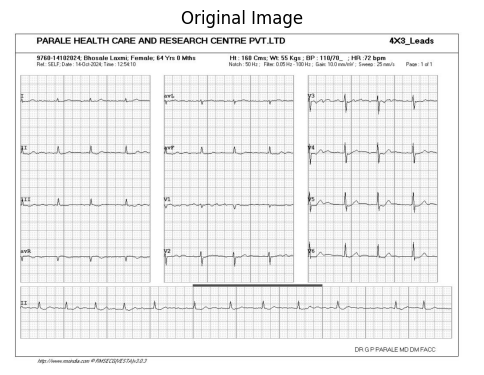

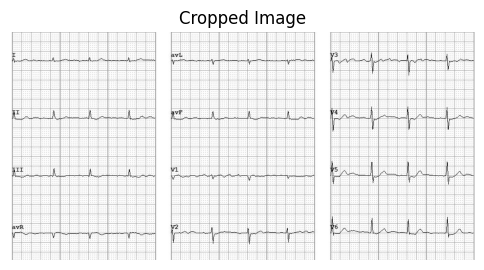


Processing Lead_1...


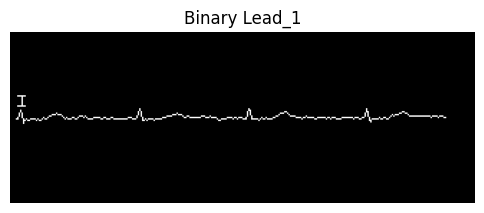

Method 1: Original EMD-based detection
Method 2: Adaptive zone-based detection
Original Method - Isoelectric Line: 58.94 pixels
Adaptive Method - Isoelectric Line: 58.86 pixels
Using adaptive method (small difference)


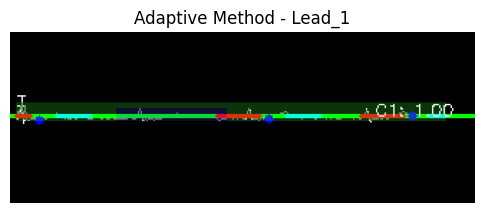

Using isoelectric baseline at y=58.86 pixels
Found 300 valid signal points in the image
Generated 324 evenly spaced points across the image width
Successfully interpolated to 5000 data points using nearest interpolation
Data Length: 5000
Sample values: ['-469.87', '-469.87', '-469.87', '-469.87', '-469.87']

Processing Lead_2...


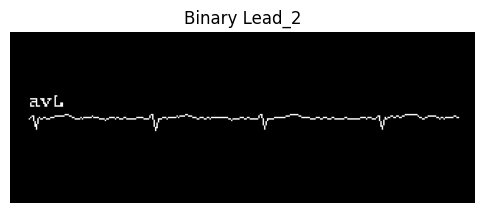

Method 1: Original EMD-based detection
Method 2: Adaptive zone-based detection
Original Method - Isoelectric Line: 58.94 pixels
Adaptive Method - Isoelectric Line: 58.86 pixels
Using adaptive method (small difference)


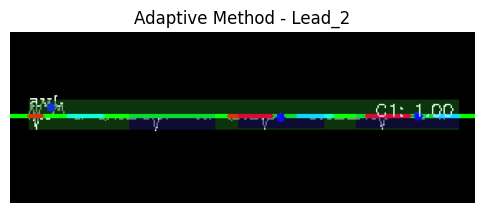

Using isoelectric baseline at y=58.86 pixels
Found 300 valid signal points in the image
Generated 324 evenly spaced points across the image width
Successfully interpolated to 5000 data points using nearest interpolation
Data Length: 5000
Sample values: ['-2914.12', '-2914.12', '-2914.12', '-2914.12', '-2914.12']

Processing Lead_3...


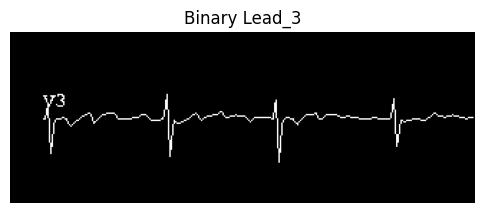

Method 1: Original EMD-based detection
Method 2: Adaptive zone-based detection
Original Method - Isoelectric Line: 60.00 pixels
Adaptive Method - Isoelectric Line: 58.92 pixels
Using adaptive method (small difference)


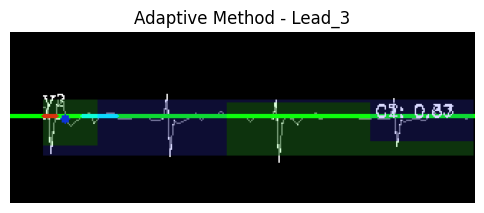

Using isoelectric baseline at y=58.92 pixels
Found 300 valid signal points in the image
Generated 324 evenly spaced points across the image width
Successfully interpolated to 5000 data points using nearest interpolation
Data Length: 5000
Sample values: ['153.67', '153.67', '153.67', '153.67', '153.67']

Processing Lead_4...


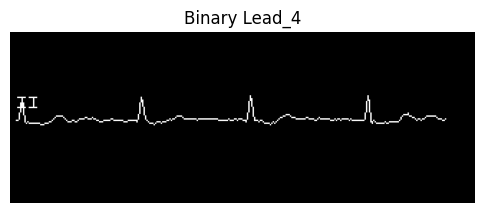

Method 1: Original EMD-based detection
Method 2: Adaptive zone-based detection
Original Method - Isoelectric Line: 59.97 pixels
Adaptive Method - Isoelectric Line: 59.92 pixels
Using adaptive method (small difference)


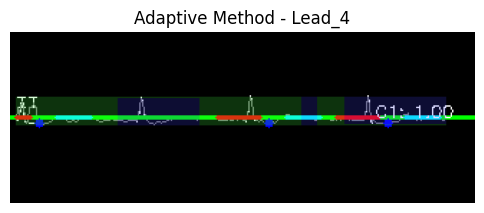

Using isoelectric baseline at y=59.92 pixels
Found 300 valid signal points in the image
Generated 324 evenly spaced points across the image width
Successfully interpolated to 5000 data points using nearest interpolation
Data Length: 5000
Sample values: ['-823.92', '-823.92', '-823.92', '-823.92', '-823.92']

Processing Lead_5...


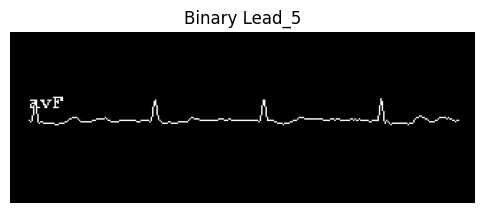

Method 1: Original EMD-based detection
Method 2: Adaptive zone-based detection
Original Method - Isoelectric Line: 60.89 pixels
Adaptive Method - Isoelectric Line: 60.74 pixels
Using adaptive method (small difference)


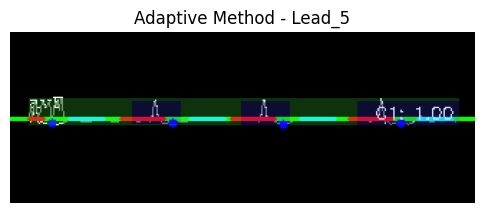

Using isoelectric baseline at y=60.74 pixels
Found 300 valid signal points in the image
Generated 324 evenly spaced points across the image width
Successfully interpolated to 5000 data points using nearest interpolation
Data Length: 5000
Sample values: ['-2894.73', '-2894.73', '-2894.73', '-2894.73', '-2894.73']

Processing Lead_6...


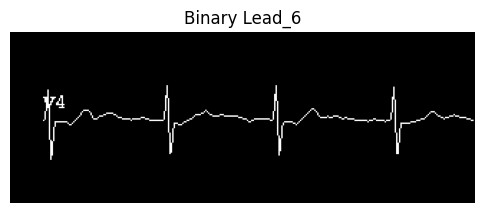

Method 1: Original EMD-based detection
Method 2: Adaptive zone-based detection
Original Method - Isoelectric Line: 59.89 pixels
Adaptive Method - Isoelectric Line: 59.75 pixels
Using adaptive method (small difference)


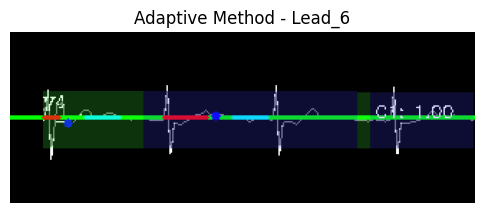

Using isoelectric baseline at y=59.75 pixels
Found 300 valid signal points in the image
Generated 324 evenly spaced points across the image width
Successfully interpolated to 5000 data points using nearest interpolation
Data Length: 5000
Sample values: ['1427.68', '1427.68', '1427.68', '1427.68', '1427.68']

Processing Lead_7...


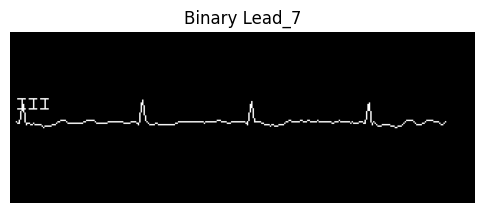

Method 1: Original EMD-based detection
Method 2: Adaptive zone-based detection
Original Method - Isoelectric Line: 61.93 pixels
Adaptive Method - Isoelectric Line: 61.85 pixels
Using adaptive method (small difference)


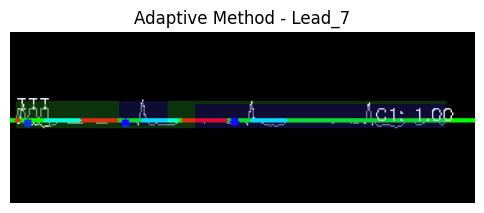

Using isoelectric baseline at y=61.85 pixels
Found 300 valid signal points in the image
Generated 324 evenly spaced points across the image width
Successfully interpolated to 5000 data points using nearest interpolation
Data Length: 5000
Sample values: ['-803.39', '-803.39', '-803.39', '-803.39', '-803.39']

Processing Lead_8...


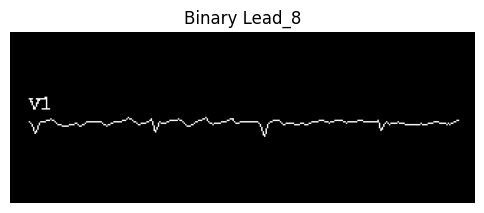

Method 1: Original EMD-based detection
Method 2: Adaptive zone-based detection
Original Method - Isoelectric Line: 61.89 pixels
Adaptive Method - Isoelectric Line: 61.74 pixels
Using adaptive method (small difference)


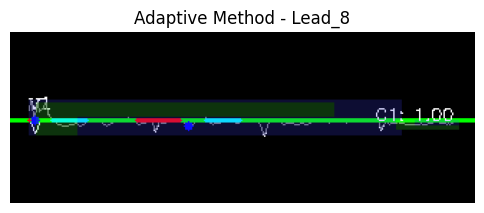

Using isoelectric baseline at y=61.74 pixels
Found 300 valid signal points in the image
Generated 324 evenly spaced points across the image width
Successfully interpolated to 5000 data points using nearest interpolation
Data Length: 5000
Sample values: ['-1705.84', '-1705.84', '-1705.84', '-1705.84', '-1705.84']

Processing Lead_9...


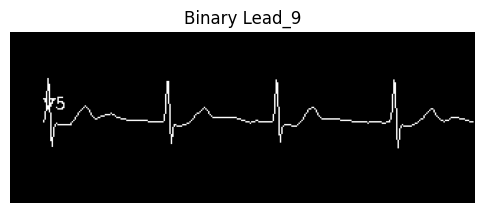

Method 1: Original EMD-based detection
Method 2: Adaptive zone-based detection
Original Method - Isoelectric Line: 61.39 pixels
Adaptive Method - Isoelectric Line: 61.91 pixels
Using adaptive method (small difference)


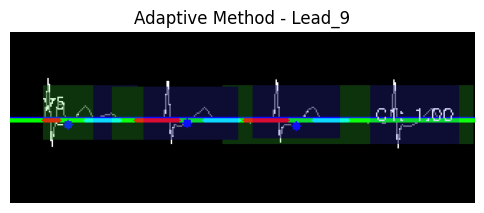

Using isoelectric baseline at y=61.91 pixels
Found 300 valid signal points in the image
Generated 324 evenly spaced points across the image width
Successfully interpolated to 5000 data points using nearest interpolation
Data Length: 5000
Sample values: ['-2535.40', '-2535.40', '-2535.40', '-2535.40', '-2535.40']

Processing Lead_10...


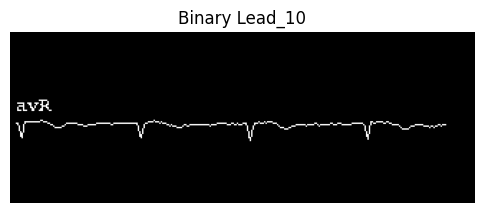

Method 1: Original EMD-based detection
Method 2: Adaptive zone-based detection
Original Method - Isoelectric Line: 63.93 pixels
Adaptive Method - Isoelectric Line: 63.83 pixels
Using adaptive method (small difference)


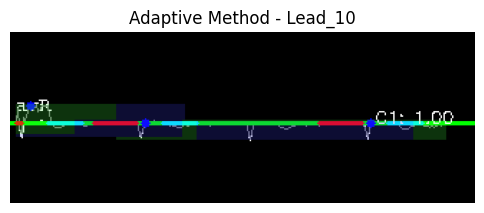

Using isoelectric baseline at y=63.83 pixels
Found 300 valid signal points in the image
Generated 324 evenly spaced points across the image width
Successfully interpolated to 5000 data points using nearest interpolation
Data Length: 5000
Sample values: ['-825.99', '-825.99', '-825.99', '-825.99', '-825.99']

Processing Lead_11...


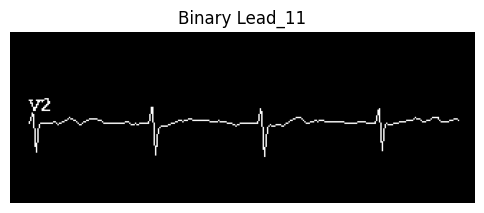

Method 1: Original EMD-based detection
Method 2: Adaptive zone-based detection
Original Method - Isoelectric Line: 62.36 pixels
Adaptive Method - Isoelectric Line: 62.83 pixels
Using adaptive method (small difference)


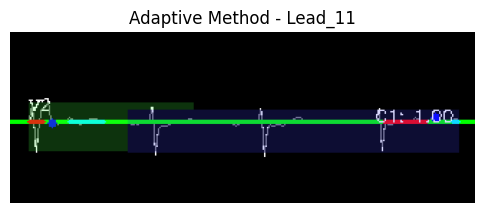

Using isoelectric baseline at y=62.83 pixels
Found 300 valid signal points in the image
Generated 324 evenly spaced points across the image width
Successfully interpolated to 5000 data points using nearest interpolation
Data Length: 5000
Sample values: ['-2292.66', '-2292.66', '-2292.66', '-2292.66', '-2292.66']

Processing Lead_12...


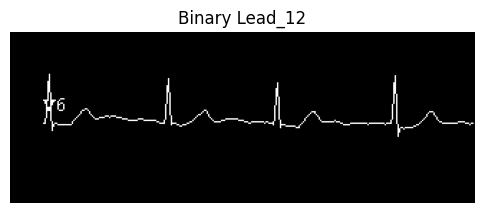

Method 1: Original EMD-based detection
Method 2: Adaptive zone-based detection
Original Method - Isoelectric Line: 62.25 pixels
Adaptive Method - Isoelectric Line: 62.58 pixels
Using adaptive method (small difference)


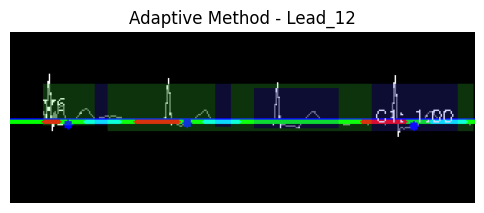

Using isoelectric baseline at y=62.58 pixels
Found 300 valid signal points in the image
Generated 324 evenly spaced points across the image width
Successfully interpolated to 5000 data points using nearest interpolation
Data Length: 5000
Sample values: ['2723.92', '2723.92', '2723.92', '2723.92', '2723.92']

Processing complete!


In [ ]:
def main():
    # Step 1: File Upload with timestamp
    image_name = "/content/9760-14102024_Bhosale Laxmi.jpg"

    # Step 2: Load Image
    image = cv.imread(image_name, flags=cv.IMREAD_GRAYSCALE)

    if image is None:
        print(f'Cannot open image: {image_name}')
        return

    display_image(image, 'Original Image')

    # Step 3: Crop Image with Boundary Check
    try:
        cropped_image = crop_image(image, 100, -195, 20, -85)
        display_image(cropped_image, 'Cropped Image')
    except Exception as e:
        print(f"Error during cropping: {e}")
        return

    # Step 4: Process Each Lead and Extract Amplitude Data
    leads = segment_leads(cropped_image)
    lead_data = {}
    isoelectric_values = {}

    for idx, lead in enumerate(leads):
        lead_name = f'Lead_{idx + 1}'
        print(f"\nProcessing {lead_name}...")

        # Standard Thresholding
        ret, binary_image = cv.threshold(lead, 100, 255, cv.THRESH_BINARY_INV)
        display_image(binary_image, f'Binary {lead_name}')

        # Compare both methods for isoelectric line detection
        print("Method 1: Original EMD-based detection")
        iso_line_original, debug_info_original = detect_isoelectric_line(binary_image, debug=True)

        print("Method 2: Adaptive zone-based detection")
        iso_line_adaptive, debug_info_adaptive = detect_isoelectric_line_adaptive(binary_image, debug=True)

        print(f"Original Method - Isoelectric Line: {iso_line_original:.2f} pixels")
        print(f"Adaptive Method - Isoelectric Line: {iso_line_adaptive:.2f} pixels")

        # Choose which method to use (can be based on comparison or fixed choice)
        # Example: Use adaptive method if the difference is small, otherwise original
        if abs(iso_line_original - iso_line_adaptive) < 20:
            iso_line = iso_line_adaptive
            debug_info = debug_info_adaptive
            method_used = "adaptive"
            print("Using adaptive method (small difference)")
        else:
            # If large difference, use the original method which is more established
            iso_line = iso_line_original
            debug_info = debug_info_original
            method_used = "original"
            print("Using original method (large difference)")

        isoelectric_values[lead_name] = iso_line

        # Visualize the detected baseline and segments
        if method_used == "adaptive":
            visual_image = visualize_adaptive_segments(binary_image, debug_info)
            display_image(visual_image, f'Adaptive Method - {lead_name}')
        else:
            visual_image = visualize_isoelectric_segments(binary_image, debug_info)
            display_image(visual_image, f'Original Method - {lead_name}')

        # Extract amplitude values using the detected isoelectric line
        amplitude_values = extract_signal(binary_image,pixels_per_mV = 0.045, isoelectric_baseline=iso_line)
        lead_data[lead_name] = amplitude_values

        print(f"Data Length: {len(amplitude_values)}")
        print(f"Sample values: {[f'{v:.2f}' for v in amplitude_values[:5]]}")

    # Step 5: Save All Data
    save_corrected_csv(lead_data)

    print("\nProcessing complete!")



if __name__ == '__main__':
    main()


In [ ]:
import pandas as pd
import ecg_plot

# Load the ECG CSV file
df = pd.read_csv('/content/trail.csv')

df = df.iloc[200:-75, :]

# Use first 12 columns as ECG leads
lead_columns = df.columns[:12]
ecg_array = [df[col].values for col in lead_columns]

# If data is in microvolts, scale to millivolts
scale_to_mV = True
if scale_to_mV:
    ecg_array = [lead / 1000 for lead in ecg_array]

# Plot ECG
ecg_plot.plot(ecg_array, sample_rate=500)  # Adjust sample rate if needed
ecg_plot.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/trail.csv'